In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsW_0261.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(100,100)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (82.23699013, 42.49066314)>


In [3]:
x = [82.150936,82.110034,82.158453,82.197666,82.182192,82.192476,82.113757,82.104471,82.095256,82.125836]
y = [42.449436,42.452321,42.478781,42.42245,42.480211,42.437444,42.478844,42.440872,42.420703,42.407897]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\2V Reduced')
file = 'reduceducdW_0261.fits'
image = pf.getdata(file)

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -10<(k-xref)<10 and -10<(l-yref)<10:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[463.02497454 636.55844268 432.48393402 263.61094047 331.95222393
 286.33780471 621.8954255  659.66630679 697.91366745 567.65227111]
[341.11244655 326.01146032 172.39451466 494.24278468 163.29273018
 408.3792328  173.63902691 391.92122831 508.0070285  580.45300136]
 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
249 461.16258 337.03771 0.53014993 ...   0 122.39825 14.832077   -2.9280049
256 454.02837 348.54499 0.89372017 ...   0 8.7840467 1.0459471 -0.048774349
 id xcentroid ycentroid sharpness  ... sky   peak      flux      mag    
--- --------- --------- ---------- ... --- -------- --------- ----------
241 636.26656 322.55466 0.60793862 ...   0 72.14853 7.6527392 -2.2095423
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
125 431.99854 170.50723 0.52843314 ...   0 1247.1952 148.40745 

In [4]:
positions = [(461.16258,337.03771),(636.26656,322.55466),(431.99854,170.50723),(258.84045,492.17191),
             (331.00093,161.46776),(284.54566,406.99498),(621.3938,171.86802),(659.17684,390.09196),
             (697.29951,506.99933),(566.43,579.62297)]

In [5]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=4) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

[  0.88561495 -22.60662793]
[[ 0.00116047 -0.01305261]
 [-0.01305261  0.1494957 ]]
Beta: [  0.78317145 -21.32445076]
Beta Std Error: [0.04346502 0.6038079 ]
Beta Covariance: [[ 3.92923125e-05 -5.40376610e-04]
 [-5.40376610e-04  7.58272522e-03]]
Residual Variance: 48.08086330710972
Inverse Condition #: 0.056038440482136215
Reason(s) for Halting:
  Sum of squares convergence


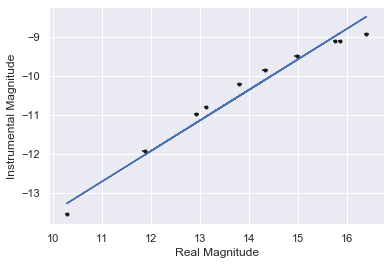

In [6]:
mags = np.array(mags)
realmag = [15.758,16.402,13.119,15.872,13.806,10.272,12.923,14.323,11.868,14.98]
realmag = np.array(realmag)
realmagerrors = [0.036,0.054,0.037,0.041,0.057,0.041,0.049,0.063,0.058,0.066]
plt.errorbar(realmag,mags,magserrors,realmagerrors,fmt='.',color='k')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def f(x,m,c):
    return m*x+c
popt, pcov = curve_fit(f,realmag,mags,sigma=magserrors)
print(popt)

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(realmag, mags, sx = realmagerrors, sy = magserrors)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*realmag+myoutput.beta[1]
plt.plot(realmag,y)
print(pcov)
myoutput.pprint()

In [7]:
xref = 410
yref = 406

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
442    566.43 579.62297 0.62485962 ...   0 283.05513 30.994495 -3.7282114
305 408.44277 406.48294 0.51767738 ...   0 22683.276 2706.1721 -8.5808885


In [8]:
sourcemag = []
sourcemagerror = []
position = [(408.44277,406.48294)]
aperture = CircularAperture(position[0], r=3) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-13.69591956130575]


In [9]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

9.740563472838323 +/- 0.941620809093688
